In [51]:
''' approaches to covert text to vector: One hot encoding, Bag of words, TF-IDF, word Embedding
-- One hot encoding and label encoding suffer from out of vocabulary (OOV) problem and not having fixed length representaion
-- Bag of Words (BOW) and CountVectorizer is used to represent text data into a vector of word counts or frequencies. BOW and Bag of n-gram suffer OOV problem
-- TF-IDF method: Term Frequency(TF) = [number of times word appeared / total no of words in a document]
Inverse Document Frequency(IDF) = [log(Total number of documents / number of documents that contains the word)]
TF-IDF = Term Frequency(TF) * Inverse Document Frequency(IDF)
'''

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import spacy 
import keras
from tensorflow.keras.preprocessing.text import  one_hot
from keras.preprocessing.sequence import pad_sequences
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

2024-10-23 09:41:47.925526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# One hot encoding method

In [37]:
reviews = ['nice food',
        'amazing restaurant',
        'too good',
        'just loved it!',
        'will go again',
        'horrible food',
        'never go there',
        'poor service',
        'poor quality',
        'needs improvement']

Y = np.array([1,1,1,1,1,0,0,0,0,0])

In [38]:
vocab_size=50
max_length=3
reviews_one_hot=[one_hot(i,vocab_size) for i in reviews]
reviews_encoder=pad_sequences(reviews_one_hot, maxlen=max_length,padding='post')
reviews_encoder

array([[43, 34,  0],
       [ 3, 25,  0],
       [ 8,  1,  0],
       [29, 12, 19],
       [16, 12,  7],
       [18, 34,  0],
       [42, 12, 36],
       [15,  7,  0],
       [15,  7,  0],
       [29,  8,  0]], dtype=int32)

In [39]:
embeded_vector_size=5
model= keras.Sequential([
       keras.layers.Embedding(input_dim=vocab_size, output_dim=embeded_vector_size,input_shape=(max_length,), name='Embedding'),
       keras.layers.Flatten(),
       keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding (Embedding)           │ (None, 3, 5)           │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266 (1.04 KB)

 Trainable params: 266 (1.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model.fit (reviews_encoder,Y, epochs=50, verbose=1)

Epoch 1/50


In [ ]:
y_pred=model.predict(reviews_encoder)
y_pred

In [ ]:
test=['poor','great','best','come again']
test_one_hot=[one_hot(i,vocab_size) for i in test]
test_encoder=pad_sequences(test_one_hot, maxlen=max_length,padding='post')
test_encoder

In [ ]:
y_pred=model.predict(test_encoder)
y=[(lambda x:1  if x>0.5 else 0)(i) for i in y_pred]
y

In [ ]:
word_embedding=model.get_layer('Embedding').get_weights()[0]

# Bag of Words (BOW) using CountVectorizer

In [13]:
# Spam email data set was taken from: https://www.kaggle.com/datasets/mfaisalqureshi/spam-email?resource=download
df=pd.read_csv("spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
df.Category.value_counts()
df['spam']=df['Category'].apply(lambda x:1 if x=='spam' else 0)
x_train,x_test,y_train,y_test=train_test_split(df.Message, df.spam,test_size=0.2)

In [16]:
vectorizer=CountVectorizer()
x_train_cv=vectorizer.fit_transform(x_train)
x_train_np=x_train_cv.toarray()

vectorizer.get_feature_names_out().shape
vectorizer.vocabulary_
vectorizer.get_feature_names_out()[1000]

'anyway'

In [17]:
x_train.head(1)
x_train[473]

'Nothing. I meant that once the money enters your account here, the bank will remove its flat rate. Someone transfered  &lt;#&gt;  to my account and  &lt;#&gt; dollars got removed. So the banks differ and charges also differ.be sure you trust the 9ja person you are sending account details to cos...'

In [18]:
words=[np.where(x_train_np[0]!=0)]       # np.nonzero(x_train_np[0])
for word in words:
    print(vectorizer.get_feature_names_out()[word])

['62468' 'ac' 'cool' 'hello' 'hi' 'posts' 'say' 'seem' 'send' 'sms' 'stop'
 'sun0819' 'to' 'wanted' 'you']


In [19]:
model=MultinomialNB()
model.fit(x_train_cv, y_train)

MultinomialNB()

In [20]:
x_test_cv=vectorizer.transform(x_test)
x_test_np=x_test_cv.toarray()
vectorizer.get_feature_names_out().shape

(7825,)

In [21]:
ypred=model.predict(x_test_cv)

In [171]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [172]:
emails = [
    'Hey mohan, can we get together to watch footbal game tomorrow?',
    'Upto 20% discount on parking, exclusive offer just for you. Dont miss this reward!'
]

emails_count = vectorizer.transform(emails)
model.predict(emails_count)

array([0, 1])

In [22]:
model=Pipeline([
    ('vectorizer', CountVectorizer()),
    ('NB', MultinomialNB())
])

model.fit(x_train,y_train)
ypred=model.predict(x_test)

print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       955
           1       0.99      0.93      0.95       160

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



# BOW of ngram using ngram_range(min_n, max_n)

In [23]:
vectorizer=CountVectorizer(ngram_range=(1,2))
vectorizer.fit(['Hey mohan, can we get together to watch footbal game tomorrow?'])
vectorizer.vocabulary_
vectorizer.transform(['can we watch footbal game?']).toarray()

array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]])

In [25]:
model=Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1,2))),
    ('NB', MultinomialNB())
])

model.fit(x_train,y_train)
ypred=model.predict(x_test)

print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       955
           1       1.00      0.91      0.95       160

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [27]:
nlp=spacy.load("en_core_web_sm")
def preprocess(text):
    filtered_text=[]
    doc=nlp(text)
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        else:
            filtered_text.append(token.lemma_)

    return(" ".join(filtered_text))

In [28]:
df['filterd_Message']=df['Message'].apply(preprocess)
x_train,x_test,y_train,y_test=train_test_split(df.filterd_Message, df.spam,test_size=0.2)

In [29]:
model=Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1,2))),
    ('NB', MultinomialNB())
])

model.fit(x_train,y_train)
ypred=model.predict(x_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       968
           1       0.97      0.93      0.95       147

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



<Axes: >

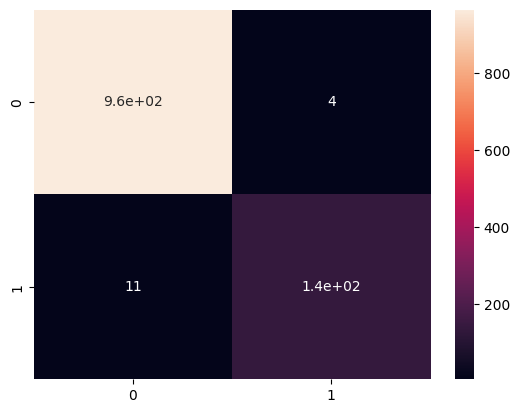

In [30]:
cm=confusion_matrix(y_test,ypred)
sn.heatmap(cm,annot=True)

# TF-IDF method 

In [31]:
text = [
    "Thor eating pizza, Loki is eating pizza, Ironman ate pizza already",
    "Apple is announcing new iphone tomorrow",
    "Tesla is announcing new model-3 tomorrow",
    "Google is announcing new pixel-6 tomorrow",
    "Microsoft is announcing new surface tomorrow",
    "Amazon is announcing new eco-dot tomorrow",
    "I am eating biryani and you are eating grapes"
]

In [32]:
vectorizer=TfidfVectorizer()
vectorizer.fit(text)
len(vectorizer.vocabulary_)
features=vectorizer.get_feature_names_out()
features

array(['already', 'am', 'amazon', 'and', 'announcing', 'apple', 'are',
       'ate', 'biryani', 'dot', 'eating', 'eco', 'google', 'grapes',
       'iphone', 'ironman', 'is', 'loki', 'microsoft', 'model', 'new',
       'pixel', 'pizza', 'surface', 'tesla', 'thor', 'tomorrow', 'you'],
      dtype=object)

In [33]:
for word in features:
    index=vectorizer.vocabulary_.get(word)
    print(word, np.round(vectorizer.idf_[index],3)) #score for each word

already 2.386
am 2.386
amazon 2.386
and 2.386
announcing 1.288
apple 2.386
are 2.386
ate 2.386
biryani 2.386
dot 2.386
eating 1.981
eco 2.386
google 2.386
grapes 2.386
iphone 2.386
ironman 2.386
is 1.134
loki 2.386
microsoft 2.386
model 2.386
new 1.288
pixel 2.386
pizza 2.386
surface 2.386
tesla 2.386
thor 2.386
tomorrow 1.288
you 2.386


In [34]:
text_transform=vectorizer.transform(text)
text_transform.toarray()[0]

array([0.24266547, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.24266547, 0.        , 0.        ,
       0.40286636, 0.        , 0.        , 0.        , 0.        ,
       0.24266547, 0.11527033, 0.24266547, 0.        , 0.        ,
       0.        , 0.        , 0.72799642, 0.        , 0.        ,
       0.24266547, 0.        , 0.        ])

In [35]:
model=Pipeline([
    ("TfidfVectorizer",TfidfVectorizer()),
    ("NB",MultinomialNB())
])

model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       968
           1       1.00      0.76      0.86       147

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

